<a href="https://colab.research.google.com/github/sindoll2/github-project/blob/main/LGBMRegressor_membranedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
myfile = files.upload()

Saving Supplementary Data.csv to Supplementary Data.csv


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from lightgbm import LGBMRegressor
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

In [2]:
df = pd.read_csv('Supplementary Data.csv', encoding='cp949')

target_col = 'Membrane Flux (LMH)'
seed = 15
print(df.shape)
df.head()

(856, 21)


,Author,Year,Membrane AL Type,Manufacture,Membrane Direction,Flow Orientation (counter/ cocurrent),Feed Solution (FS),Draw Solution (DS),FS Molarity (M),FS Osmotic pressure (atm),...,DS Molecular weight,DS Osmotic pressure (atm),P Difference (atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature (°C),DS Temperature (°C),A (LMH/atm),S (um),Membrane Flux (LMH)
0,Gray,2006,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,180.156,5.56,5.56,30.0,30.0,22.5,22.5,0.99,NaN,5.50
1,Gray,2006,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,180.156,23.19,23.19,30.0,30.0,22.5,22.5,0.99,NaN,22.96
2,Gray,2006,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,180.156,29.45,29.45,30.0,30.0,22.5,22.5,0.99,NaN,29.16
3,Gray,2006,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,180.156,43.58,43.58,30.0,30.0,22.5,22.5,0.99,NaN,43.15
4,Gray,2006,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,180.156,17.11,17.11,30.0,30.0,22.5,22.5,0.99,NaN,16.94


In [3]:
df['FS Velocity (cm/s)'].fillna(df['FS Velocity (cm/s)'].mean(), inplace=True)
df['DS Velocity (cm/s)'].fillna(df['DS Velocity (cm/s)'].mean(), inplace=True)
df['A (LMH/atm)'].fillna(df['A (LMH/atm)'].mean(), inplace=True)
df['S (um)'].fillna(df['S (um)'].mean(), inplace=True)
df.drop(['S (um)'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Author                                 856 non-null    object 
 1   Year                                   856 non-null    int64  
 2   Membrane AL Type                       856 non-null    object 
 3   Manufacture                            856 non-null    object 
 4   Membrane Direction                     856 non-null    object 
 5   Flow Orientation (counter/ cocurrent)  856 non-null    object 
 6   Feed Solution (FS)                     856 non-null    object 
 7   Draw Solution (DS)                     856 non-null    object 
 8   FS Molarity (M)                        856 non-null    float64
 9   FS Osmotic pressure (atm)              856 non-null    float64
 10  DS Molarity (M)                        856 non-null    float64
 11  DS Mol

In [10]:
df['Year'] = pd.to_datetime(df['Year'])
print(df['Year'].dtype)

datetime64[ns]


In [ ]:
df.fillna(0, inplace=True)
df.info()

In [4]:
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64]and x != target_col] 
cat_cols = ['Author', 'Membrane AL Type', 'Manufacture', 'Membrane Direction','Flow Orientation (counter/ cocurrent)','Feed Solution (FS)','Draw Solution (DS)']
print(f'    numeric ({len(num_cols)}):\t{num_cols}')
print(f'categorical ({len(cat_cols)}):\t{cat_cols}')

    numeric (13):	['Year', 'FS Molarity (M)', 'FS Osmotic pressure (atm)', 'DS Molarity (M)', 'DS Molecular weight', 'DS Osmotic pressure (atm)', 'P Difference (atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature (°C)', 'DS Temperature (°C)', 'A (LMH/atm)', 'S (um)']
categorical (7):	['Author', 'Membrane AL Type', 'Manufacture', 'Membrane Direction', 'Flow Orientation (counter/ cocurrent)', 'Feed Solution (FS)', 'Draw Solution (DS)']


In [7]:
print(cat_cols)

['Author', 'Membrane AL Type', 'Manufacture', 'Membrane Direction', 'Flow Orientation (counter/ cocurrent)', 'Feed Solution (FS)', 'Draw Solution (DS)']


In [ ]:
pd.DataFrame(df['S (um)'].value_counts())

**수치형/시계열변수**

In [5]:
df[['Year', 'FS Molarity (M)', 'FS Osmotic pressure (atm)', 'DS Molarity (M)', 'DS Molecular weight', 'DS Osmotic pressure (atm)', 'P Difference (atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature (°C)', 'DS Temperature (°C)', 'A (LMH/atm)', 'S (um)', 'Membrane Flux (LMH)']] = df[['Year', 'FS Molarity (M)', 'FS Osmotic pressure (atm)', 'DS Molarity (M)', 'DS Molecular weight', 'DS Osmotic pressure (atm)', 'P Difference (atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature (°C)', 'DS Temperature (°C)', 'A (LMH/atm)', 'S (um)', 'Membrane Flux (LMH)']].apply(np.log1p)
df[num_cols].describe()

,Year,FS Molarity (M),FS Osmotic pressure (atm),DS Molarity (M),DS Molecular weight,DS Osmotic pressure (atm),P Difference (atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature (°C),DS Temperature (°C),A (LMH/atm),S (um)
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,7.608152,0.079701,0.713962,0.725931,4.276293,3.740564,3.652394,2.562251,2.553249,3.227651,3.211930,0.371986,6.353703
std,0.001836,0.173569,1.141786,0.398388,0.351732,0.837617,0.864486,1.100702,1.104783,0.172702,0.135936,0.248545,0.190857
min,7.604396,0.000000,0.000000,0.039221,3.883726,1.041372,0.000000,0.350657,0.350657,3.044522,3.043570,0.039221,5.700444
25%,7.606885,0.000000,0.000000,0.405465,4.084967,3.158489,3.151453,2.251292,2.251292,3.044522,3.044522,0.165514,6.372398
50%,7.608374,0.000000,0.000000,0.693147,4.084967,3.822973,3.739335,3.037996,3.034801,3.258097,3.258097,0.350657,6.372398
75%,7.609367,0.086178,1.578979,0.916291,4.324808,4.288245,4.220728,3.258097,3.258097,3.258097,3.258097,0.462286,6.372398
max,7.611842,0.891998,4.065087,1.945910,5.993662,5.970269,5.897751,4.813971,4.813971,3.931826,3.713572,1.358409,7.113142


In [12]:
df['Year'] = df['Year'].dt.year
df.head()

,Author,Year,Membrane AL Type,Manufacture,Membrane Direction,Flow Orientation (counter/ cocurrent),Feed Solution (FS),Draw Solution (DS),FS Molarity (M),FS Osmotic pressure (atm),...,DS Molecular weight,DS Osmotic pressure (atm),P Difference (atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature (°C),DS Temperature (°C),A (LMH/atm),S (um),Membrane Flux (LMH)
0,Gray,1970,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,1.880991,1.880991,3.433987,3.433987,3.157,3.157,0.688135,0.0,1.871802
1,Gray,1970,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.185939,3.185939,3.433987,3.433987,3.157,3.157,0.688135,0.0,3.176386
2,Gray,1970,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.416086,3.416086,3.433987,3.433987,3.157,3.157,0.688135,0.0,3.406517
3,Gray,1970,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.797285,3.797285,3.433987,3.433987,3.157,3.157,0.688135,0.0,3.787593
4,Gray,1970,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,2.896464,2.896464,3.433987,3.433987,3.157,3.157,0.688135,0.0,2.887033


In [13]:
num_cols += ['Year']
print(num_cols)

features = num_cols + cat_cols

['Year', 'FS Molarity (M)', 'FS Osmotic pressure (atm)', 'DS Molarity (M)', 'DS Molecular weight', 'DS Osmotic pressure (atm)', 'P Difference (atm)', 'FS Velocity (cm/s)', 'DS Velocity (cm/s)', 'FS Temperature (°C)', 'DS Temperature (°C)', 'A (LMH/atm)', 'S (um)', 'Year']


In [5]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y,p))
rmsle = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X = hstack((df[num_cols],
            ohe.fit_transform(df[cat_cols])))
print(X.shape)

(856, 98)


In [10]:
df.head()

,Author,Year,Membrane AL Type,Manufacture,Membrane Direction,Flow Orientation (counter/ cocurrent),Feed Solution (FS),Draw Solution (DS),FS Molarity (M),FS Osmotic pressure (atm),...,DS Molecular weight,DS Osmotic pressure (atm),P Difference (atm),FS Velocity (cm/s),DS Velocity (cm/s),FS Temperature (°C),DS Temperature (°C),A (LMH/atm),S (um),Membrane Flux (LMH)
0,Gray,7.604396,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,1.880991,1.880991,3.433987,3.433987,3.157,3.157,0.688135,6.372398,1.871802
1,Gray,7.604396,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.185939,3.185939,3.433987,3.433987,3.157,3.157,0.688135,6.372398,3.176386
2,Gray,7.604396,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.416086,3.416086,3.433987,3.433987,3.157,3.157,0.688135,6.372398,3.406517
3,Gray,7.604396,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,3.797285,3.797285,3.433987,3.433987,3.157,3.157,0.688135,6.372398,3.787593
4,Gray,7.604396,CTA,HTI,AL-FS,cocurrent,DI,Dextrose,0.0,0.0,...,5.199359,2.896464,2.896464,3.433987,3.433987,3.157,3.157,0.688135,6.372398,2.887033


In [19]:
from sklearn.preprocessing import StandardScaler

X_trn, X_tst, y_trn, y_tst = train_test_split(X, df[target_col], test_size=.2, random_state=seed)
clf = LGBMRegressor(random_state=seed)
clf.fit(X_trn, np.log1p(y_trn))
p = np.expm1(clf.predict(X_tst))






if('Membrane Flux (LMH)' in df.keys()):
    print(df['Membrane Flux (LMH)'])
else:
    print('Membrane Flux (LMH) not found')

print('RMSE : ', mean_squared_error(y_tst, p, squared = False))



0       5.5000
1      22.9600
2      29.1600
3      43.1500
4      16.9400
        ...   
851     0.1800
852     0.9288
853     1.1412
854     1.6884
855     1.8468
Name: Membrane Flux (LMH), Length: 856, dtype: float64
RMSE :  3.054599490156482


In [8]:
from sklearn.metrics import accuracy_score
print('accuracy:', accuracy_score(y_tst, p))

ValueError: ignored

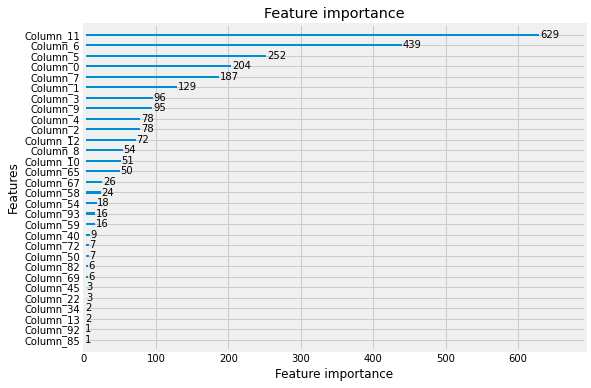

In [19]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(clf, ax=ax)
plt.show()